In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, curve_fit as cf

plt.style.use('seaborn-ticks')

font = {'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)

params = {'figure.figsize': (10, 10), 
         'axes.labelsize': 20, 
         'legend.fontsize': 20, 
          'axes.labelweight': 'bold', 
         'axes.titlesize': 20, 
         'xtick.labelsize': 20, 
         'ytick.labelsize': 20, 
         'lines.linewidth': 3, 
         'axes.linewidth': 3, 
         'xtick.major.size': 20, 
         'xtick.major.width': 3, 
         'xtick.minor.size': 10, 
         'xtick.major.width': 3, 
         'ytick.major.size': 20, 
         'ytick.major.width': 3, 
         'ytick.minor.size': 10, 
         'ytick.major.width': 3}

plt.rcParams.update(params)

/tmp/ipykernel_131754/1633375411.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


In [2]:
# unit conversion factors

my_unit = {'distance': 3.1e19,      # converts distance into [SI]
          'mass': 5.303e37,         # converts mass into [SI]
          'density': 1.78e-21,      # converts density into [SI]
          'potential': 1.71e7}     # converts potential into [10^11 SI]

In [3]:
# global constants
G = 6.67e-11 # Newton's universal gravitational constant
R_ref = 1e7 #   (in kpc) 
rsat = 50  # in kpc (radius after which mass of baryons saturate)

# milky-way constants

R0 = 8.5 # in kpc
ρdm0 = 0.09 # in GeV/cc
rs = 74.582 # in kpc
ρb0 = 11120 # in GeV/cc
rb = 0.0905 # in kpc
ρdisk0 = 5.24 # (in unit of [S/R]) in GeV/cc 
Rd = 4.251 # in kpc
zd = 0.34 # in kpc

In [4]:
# defining masses for the Milky-way

def Mbulge(r): 
    
    return 4*np.pi*ρb0*(np.arcsinh(r/rb)*rb**3-r*rb**4*np.sqrt(1+r**2/rb**2)/(r**2+rb**2))

def Mdisk(r): # using thick disk from the Sayan's Mathematica code
    
    return 2*np.pi*ρdisk0*Rd*(Rd - np.exp(-r/Rd)*(r + Rd))*np.exp(R0/Rd)

def Mbar(r):
    
    mbar = Mbulge(r) + Mdisk(r)
    
    return mbar

# mass of baryons within the shell of radius $rsat$
mbar_saturation = Mbar(rsat)

In [5]:
# total mass, including baryons, keeping saturation of baryonic components into mind

def Mtot(xr):
    
    if(xr <= rsat):
        
        return Mbar(xr) + 4*np.pi*ρdm0*R0/rs*(1 + R0/rs)**2*rs**3*(np.log(1 + xr/rs) - xr/(rs + xr))
    
    else:
        
        return mbar_saturation + 4*np.pi*ρdm0*R0/rs*(1 + R0/rs)**2*rs**3*(np.log(1 + xr/rs) - xr/(rs + xr))

In [6]:
rmass = np.logspace(-2, 7, 700) # in kpc, 10^7 kpc in treated at infiniity while evaluating potential
mtot = np.zeros(len(rmass))

for i, xr in enumerate(rmass):
    
    mtot[i] = Mtot(xr)

In [7]:
MtotIntFun = interp1d(rmass, mtot, kind='cubic', fill_value='extrapolate')

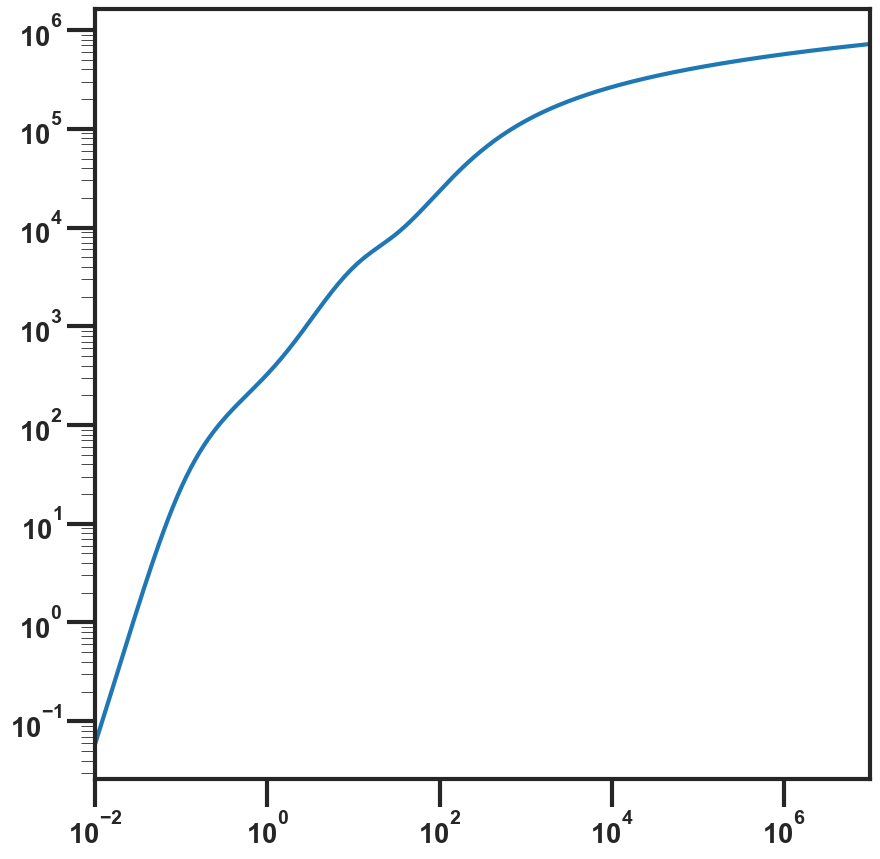

In [8]:
plt.plot(rmass, mtot)

plt.xlim([1e-2, 1e7])
plt.xscale('log')
plt.yscale('log')

In [9]:
def Vbar(r):
    
    if (r > rsat):
        
        return -G*Mbar(rsat)/r
    
    else:
    
        integrand = lambda xr: Mbar(xr)/xr**2
        
        return -G*quad(integrand, r, rsat, limit=10000)[0] - G*Mbar(rsat)/rsat

def VTotal(r):
    
    return  Vbar(r) - 4*np.pi*G*ρdm0*R0/rs*(1 + R0/rs)**2*rs**3*np.log(1 + r/rs)/r

In [10]:
r_ϕ = np.logspace(-2, 7, 400)
PhiT = np.zeros(len(r_ϕ))

for i in range(len(r_ϕ)):
    
    PhiT[i] = -VTotal(r_ϕ[i])*my_unit['potential']

In [11]:
# defining the interpolating function for the scaled-potential, ϕ.

PhiIntFun = interp1d(r_ϕ, PhiT, kind='cubic', fill_value='extrapolate')

In [12]:
def ρdm(r): # NFW-profile for the DM
    
    return ρdm0*(R0/r)*((R0+rs)/(rs+r))**2

def vmax(r): # escape velocity of the DM particles
    
    return np.sqrt(2*PhiIntFun(r))

In [13]:
def dρdr(r):
    return -ρdm0*R0*(R0+rs)**2*(3*r+rs)/r**2/(r+rs)**3

def dϕdr(r):
    return -G*MtotIntFun(r)/r**2

def dρdϕ(r):
    return dρdr(r)/dϕdr(r)

def d2ρdϕdr(r):
    return -derivative(dρdϕ, r, dx=1e-3, order=3)

In [14]:
dpx = np.logspace(-2, 7, 400)
d2ρdφdrT = np.zeros(len(dpx))

for i in range(len(dpx)):
    
    d2ρdφdrT[i] = d2ρdφdr(dpx[i])/my_unit['potential']

In [15]:
d2ρdφdrFun=interp1d(dpx, d2ρdφdrT, kind='cubic', fill_value='extrapolate')

In [16]:
# main function for finding the VDFs. it will be fed into a parallelized pipeline.

n=32 # number of points at which VDF will be sampled
def find_VDF(Ra):
    rhohere=ρdm(Ra)
    vM=vmax(Ra)
    v=np.ones(n)
    for i in range(0,n,1):
        v[i]=(i/(n-1))*vM
    Ene=np.ones(n)
    for i in range(0,n,1):
        Ene[i]=PhiIntFun(Ra)-0.5*v[i]**2
    Rz=np.ones(n)
    for i in range(0,n-1,1):
        def eqsn(x):
            return PhiIntFun(x)- Ene[i]
        Rz[i]=fsolve(eqsn,x0=Ra)
    I=np.zeros(n)
    for i in range(0,n-1,1):
        def integrand(x):
            x=np.array(x)
            return (1./np.sqrt(abs(Ene[i]-PhiIntFun(x))))*d2ρdφdrFun(x)*(1/(np.sqrt(8)*np.pi**2))
        I[i]=quad(integrand,Rz[i],1000*Rz[i],points=Rz[i],limit=10000)[0]
    vdist=np.ones(n)
    vdist=I/rhohere
    distr=np.ones(n)
    distr=4.*np.pi*v**2*vdist
    # v & f(v) in proper units
    v=v*np.sqrt(10) # sqrt(10) converts v in unit 100Km/s
    distr=distr/np.sqrt(10) # sqrt(10)>> converting f(v) in unit corresponding to [v]
    vdf=np.vstack((v,distr))
    return vdf.transpose()

In [17]:
vdf = find_VDF(10)

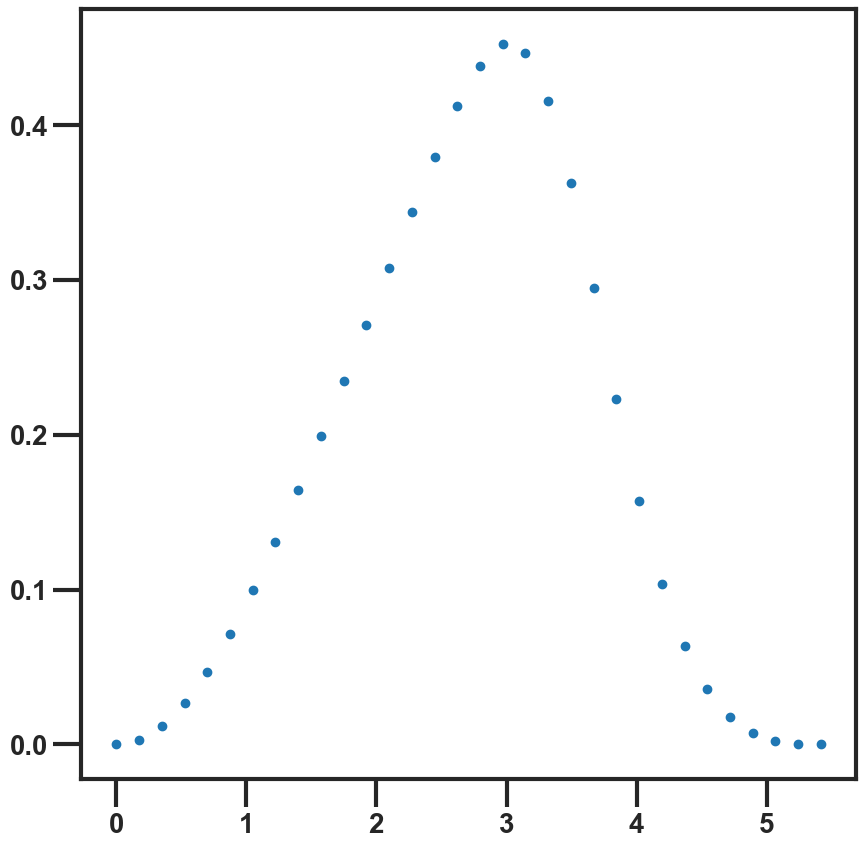

In [21]:
plt.scatter(vdf[:, 0], vdf[:, 1])

# plt.legend()

In [22]:
# testing the normalization of above computed VDF

np.trapz(vdf[:, 1], vdf[:, 0])

1.0000033216097557